## Import libraries


In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer as pc
import pystac_client
import rioxarray
from odc.stac import load

root_dir = "/beegfs/halder/GITHUB/RESEARCH/INDI-Res/"
os.chdir(root_dir)
data_dir = os.path.join(root_dir, "data")

## Read the datasets


In [2]:
# Read the shapefile of India
india_boundary_path = os.path.join(
    data_dir, "external", "India_Boundary", "India_Country_Boundary.shp"
)
india_boundary = gpd.read_file(india_boundary_path)
print(india_boundary.shape)
india_boundary.head()

(253, 2)


,Area,geometry
0,34.567532,"MULTIPOLYGON (((8135256.29 930182.487, 8135260..."
1,7658.811873,"MULTIPOLYGON (((10341718.474 1449533.161, 1034..."
2,0.189256,"POLYGON ((8738079.921 1015796.91, 8738024.198 ..."
3,0.190283,"POLYGON ((8849448.115 1020142.339, 8849498.727..."
4,0.022418,"POLYGON ((8848644.239 1020377.781, 8848625.487..."


In [3]:
# Read the Global DAM Watch v1.0 database for India
gdw_reservoirs_IN = gpd.read_file(
    os.path.join(data_dir, "processed", "GDW_reservoirs_v1_0_IN.gpkg")
)
gdw_reservoirs_IN.geometry = gdw_reservoirs_IN.geometry.buffer(distance=1000)
gdw_reservoirs_IN["area"] = gdw_reservoirs_IN.area / 1e6
gdw_reservoirs_IN.sort_values(by="area", ascending=False, inplace=True)
gdw_reservoirs_IN.to_crs(crs="EPSG:4326", inplace=True)
print(gdw_reservoirs_IN.shape)
gdw_reservoirs_IN.head()

(6201, 73)


,GDW_ID,RES_NAME,DAM_NAME,ALT_NAME,DAM_TYPE,LAKE_CTRL,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,...,LAT_DAM,ORIG_SRC,POLY_SRC,GRAND_ID,HYRIV_ID,INSTREAM,HYLAK_ID,HYBAS_L12,geometry,area
329,6951,None,Indirasagar,None,Dam,None,Narmada,None,Narmada,None,...,0.0,GRanD,JRC-GSW,6992,41114666,Instream,1427811,4120999360,"POLYGON ((76.41666 22.24478, 76.41637 22.24536...",1581.627915
21,355,Srisailam Reservoir,Srisailam,None,Dam,None,Krishna,None,Krishna-Godavari,None,...,0.0,GRanD,McGill,4991,41290465,Instream,1524,4121099710,"POLYGON ((77.94934 16.09389, 77.94919 16.09384...",1168.216509
3,325,Gandhi,Gandhi Sagar,Gandhisagar Reservoir,Dam,None,Local Nalla,None,Ganges,None,...,0.0,GRanD,McGill,4843,40992988,Instream,1484,4120932040,"POLYGON ((75.21932 24.30432, 75.21925 24.30432...",973.391063
10,336,Hirakud,Hirakud,None,Dam,None,Mahanadi,None,Mahanadi,None,...,0.0,GRanD,SWBD,4898,41146438,Instream,1502,4121017990,"POLYGON ((83.51211 21.73409, 83.5121 21.7341, ...",941.548183
4,326,Govind Ballabah Pant,Rihand,Gobind Ballabh Pant Sagar,Dam,None,Rihand,None,None,None,...,0.0,GRanD,SWBD,4858,41017753,Instream,1487,4121512910,"POLYGON ((82.5994 24.04547, 82.59939 24.04556,...",746.627106


## Search the STAC API


In [ ]:
API_URL = "https://hda.data.destination-earth.eu/stac/v2"
client = pystac_client.Client.open(API_URL)

bbox = list(gdw_reservoirs_IN.iloc[1].geometry.bounds)

search = client.search(
    collections=["EO.ECMWF.DAT.CAMS_GLOBAL_RADIATIVE_FORCING_AUX"],
    bbox=bbox,
    datetime="2001-01-01/2002-01-01",
)

items = [pc.sign(i) for i in search.get_all_items()]
print(f"Found {len(items)} scenes matching your criteria.")

APIError: {"error":"access denied to read EO.ECMWF.DAT.CAMS_GLOBAL_RADIATIVE_FORCING_AUX items"}

In [14]:
# Get all collections
collections = client.get_collections()

# Print basic info about each collection
for col in collections:
    print(f"ID: {col.id}")
    print(f"Title: {col.title}")
    print(f"Description: {col.description}\n")

ID: EO.AERIS.DAT.IAGOS
Title: In-service Aircraft for a Global Observing System
Description: In-service Aircraft for a Global Observing System (IAGOS) is a European Research Infrastructure for global observations of atmospheric composition from commercial aircraft. IAGOS combines the expertise of scientific institutions with the infrastructure of civil aviation in order to provide essential data on climate change and air quality at a global scale. In order to provide optimal information, two complementary systems have been implemented, (i) IAGOS-CORE providing global coverage on a day-to-day basis of key observables and (ii) IAGOS-CARIBIC providing a more in-depth and complex set of observations with lesser geographical and temporal coverage.
## How to cite IAGOS data
Use of the data requires proper reference and citation of the IAGOS data, using the exact citation (including the provided DOI) as provided at the moment of upload from IAGOS, if applicable. For all of the IAGOS data we w

## Read the assets


In [15]:
# Display the available assets for the first item
assets_df = pd.DataFrame.from_dict(items[0].assets, orient="index").reset_index()
assets_df.columns = ["asset", "href"]
print(assets_df.shape)
assets_df.head()

IndexError: list index out of range

## Load the data


In [34]:
# Load Data into Memory (Lazy Loading)
data = load(
    items=items,
    band=["green", "nir08"],
    bbox=bbox,
    resolution=30,
    groupby="solar_day",
    chunks={"x": 2048, "y": 2048},
)

data

<xarray.Dataset> Size: 5GB
Dimensions:        (y: 1708, x: 3778, time: 23)
Coordinates:
  * y              (y) float64 14kB 1.801e+06 1.801e+06 ... 1.75e+06 1.75e+06
  * x              (x) float64 30kB 8.054e+05 8.055e+05 ... 9.187e+05 9.188e+05
    spatial_ref    int32 4B 32643
  * time           (time) datetime64[ns] 184B 2001-01-14T05:00:33.236888 ... ...
Data variables: (12/19)
    qa             (time, y, x) int16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    red            (time, y, x) uint16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    blue           (time, y, x) uint16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    drad           (time, y, x) int16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    emis           (time, y, x) int16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    emsd           (time, y, x) int16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    ...             ...
    swir16         (time, y, x) uint16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    swir22         (time, y, x) uint16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    cloud_qa       (time, y, x) uint8 148MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    qa_pixel       (time, y, x) uint16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    qa_radsat      (time, y, x) uint16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>
    atmos_opacity  (time, y, x) int16 297MB dask.array<chunksize=(1, 1708, 2048), meta=np.ndarray>

## Calculate NDWI


Streaming pixels and plotting... this may take 10-20 seconds.


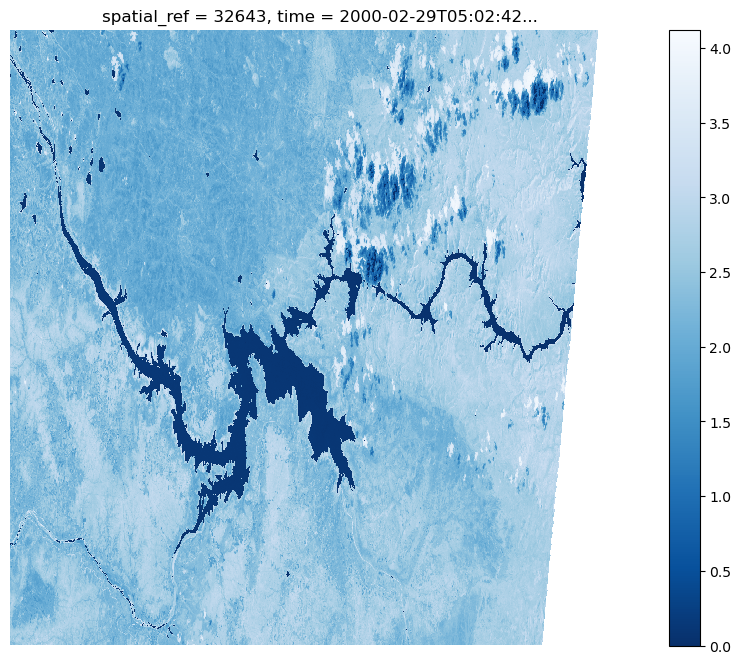

In [ ]:
ndwi = (data.green - data.nir08) / (data.green + data.nir08)

print("Streaming pixels and plotting... this may take 10-20 seconds.")
ndWi_snapshot = ndwi.isel(time=0).compute()

plt.figure(figsize=(10, 8))
ndWi_snapshot.plot.imshow(cmap="Blues_r", robust=False)
# plt.title(f"NDWI: {data.time[0].dt.date.item()}")
plt.axis("off")
plt.show()

Streaming pixels and plotting... this may take 10-20 seconds.


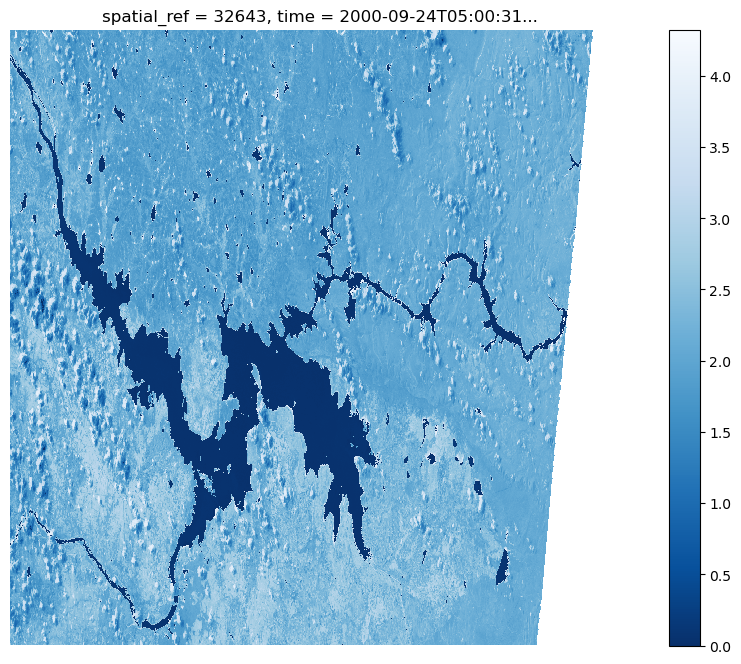

In [ ]:
ndwi = (data.green - data.nir08) / (data.green + data.nir08)

print("Streaming pixels and plotting... this may take 10-20 seconds.")
ndWi_snapshot = ndwi.isel(time=9).compute()

plt.figure(figsize=(10, 8))
ndWi_snapshot.plot.imshow(cmap="Blues_r", robust=False)
# plt.title(f"NDWI: {data.time[0].dt.date.item()}")
plt.axis("off")
plt.show()

In [49]:
ndWi_snapshot

<xarray.DataArray (y: 1708, x: 3778)> Size: 52MB
array([[1.86929144, 1.90311293, 1.88257736, ...,        nan,        nan,
               nan],
       [1.88928313, 1.96471703, 1.88467573, ...,        nan,        nan,
               nan],
       [1.88694455, 1.9550653 , 1.87533104, ...,        nan,        nan,
               nan],
       ...,
       [2.17071215, 2.07764193, 2.10500393, ...,        nan,        nan,
               nan],
       [2.30755389, 2.09214555, 2.073412  , ...,        nan,        nan,
               nan],
       [2.340874  , 2.03542617, 2.00486111, ...,        nan,        nan,
               nan]], shape=(1708, 3778))
Coordinates:
  * y            (y) float64 14kB 1.801e+06 1.801e+06 ... 1.75e+06 1.75e+06
  * x            (x) float64 30kB 8.054e+05 8.055e+05 ... 9.187e+05 9.188e+05
    spatial_ref  int32 4B 32643
    time         datetime64[ns] 8B 2001-10-29T04:58:21.999621

In [ ]:
ndwi = (data.green - data.nir08) / (data.green + data.nir08)

print("Streaming pixels and plotting... this may take 10-20 seconds.")
ndWi_snapshot = ndwi.isel(time=23).compute()

plt.figure(figsize=(10, 8))
ndWi_snapshot.plot.imshow(cmap="Blues_r", robust=False)
# plt.title(f"NDWI: {data.time[0].dt.date.item()}")
plt.axis("off")
plt.show()

Streaming pixels and plotting... this may take 10-20 seconds.


IndexError: Index 23 is out of bounds for axis 0 with size 23